# Feature Selection Notebook:

This notebook contains the code for preprocessing and feature selection.

We run the `preprocess_and_train` function from `preptrain.py` and save the selected features to a separate .csv file, `df_selected.csv`, which we use in our models in the `Models.ipynb`.

In [12]:
import pandas as pd
import numpy as np
import time

import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')
from pltcorrheatmap import plot_corr_heatmap
from preptrain import preprocess_and_train
from print_imps import print_importances, print_dict_imps, avg_imps

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel, RFE, RFECV, mutual_info_regression
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA

from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer

In [13]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")

In [14]:
print(df.shape)
print(df_last.shape)

(11282, 53)
(1665, 53)


In [4]:
start_time = time.time()

# Call the function to preprocess the data and perform feature selection
(features_rf,
 features_Dtree,
 features_pca, 
 features_rfecv, 
 features_gbm,
 features_svr, 
 features_Xtrees,
 features_Ada,
 features_XGB,
 feature_importances) = preprocess_and_train(df, df_last, labels)

end_time = time.time()
execution_time = end_time - start_time
print(f"Feature Selection execution time: {round(execution_time/60, 2)} minutes")

/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'sqrt', 4, 20] before, using random point [10, 'sqrt', 10, 7]
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'sqrt', 5, 20] before, using random point [3, 'log2', 2, 13]
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [3, 'log2', 2, 11] before, using random point [3, 'sqrt', 7, 15]
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 'sqrt', 2, 2] before, using random point [10, 'sqrt', 3, 3]
  warnings.warn(
/home/bdr6qz/.local/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has bee

Feature Selection execution time: 10.46 minutes


In [5]:
# Print selected features
print("RF:", features_rf)
print(f"PCA 1: {features_pca[0]}")
print("RFECV:", features_rfecv)
print("GBM:", features_gbm)
print("SVR:", features_svr)
print("Xtrees:", features_Xtrees)
print("AdaBoost:", features_Ada)
print("XGBoost:", features_XGB)

RF: ['WS', 'VORP', 'BPM', 'PER', 'OBPM', 'WS/48', 'Rk_Year', 'Rk_Conf', 'OWS', 'Overall']
PCA 1: ['FGA', 'FT', 'VORP', 'MP', 'FTA', '2P', 'PER', 'FG', 'PTS', 'WS']
RFECV: ['2P', 'FGA', '3P%', '3PA', 'MP', 'GS', '3P', 'FG', 'FG%', 'G']
GBM: ['WS', 'PER', 'PTS', 'VORP', 'BPM', 'DWS', 'Overall', 'WS/48', 'Rk_Conf', '2P']
SVR: ['MP', 'TS%', 'TRB%', 'TOV', 'WS/48', 'OWS', 'DRB%', 'FTA', 'eFG%', 'FT']
Xtrees: ['VORP', 'WS', 'PER', 'BPM', 'WS/48', 'Rk_Conf', 'Rk_Year', 'OBPM', 'Overall', 'OWS']
AdaBoost: ['PER', 'VORP', 'BPM', 'WS/48', 'WS', 'Rk_Year', 'Rk_Conf', 'TOV', 'OBPM', 'DWS']
XGBoost: ['VORP', 'Rk_Conf', 'PER', 'WS', 'Rk_Year', 'FGA', 'PTS', 'AST', 'OBPM', 'height']


In [6]:
print_dict_imps(feature_importances)

       Random Forest                 Decision Tree                      PCA                           GBM             
│ Feature   │   Importance │  │ Feature   │   Importance │  │ Feature   │   Importance │  │ Feature   │   Importance │
╞═══════════╪══════════════╡  ╞═══════════╪══════════════╡  ╞═══════════╪══════════════╡  ╞═══════════╪══════════════╡
│ Rk_Year   │      0.0282  │  │ WS        │      0.04261 │  │ WS        │      0.21956 │  │ Overall   │      0.02198 │
├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤
│ Rk_Conf   │      0.01589 │  │ USG%      │      0.00199 │  │ PTS       │      0.21866 │  │ WS/48     │      0.01711 │
├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤  ├───────────┼──────────────┤
│ WS/48     │      0.00636 │  │ FTr       │      3e-05   │  │ FG        │      0.21612 │  │ 2P        │      0.01287 │
├───────────┼──────────────┤  ├───────────┼─────

In [7]:
avg_imp = avg_imps(feature_importances)

1. OWS: 0.35701
2. MP: 0.11889
3. FT: 0.11285
4. 2P: 0.11095
5. FG: 0.10806
6. FGA: 0.10553
7. FTA: 0.10344
8. PTS: 0.07740
9. WS: 0.04105
10. VORP: 0.03473
11. PER: 0.03367
12. TOV: 0.01995
13. AST: 0.01787
14. TS%: 0.01356
15. Rk_Year: 0.01122
16. Overall: 0.00967
17. Rk_Conf: 0.00649
18. WS/48: 0.00529
19. OBPM: 0.00493
20. DWS: 0.00343
21. BPM: 0.00276
22. DRB%: 0.00216
23. USG%: 0.00199
24. height: 0.00182
25. TRB%: 0.00029
26. eFG%: 0.00016
27. FTr: 0.00003
28. DBPM: 0.00000
Top 10 Features: ['OWS', 'MP', 'FT', '2P', 'FG', 'FGA', 'FTA', 'PTS', 'WS', 'VORP']


### These are interesting, but we know many of the features related to points (scoring) are highly correlated, for example:

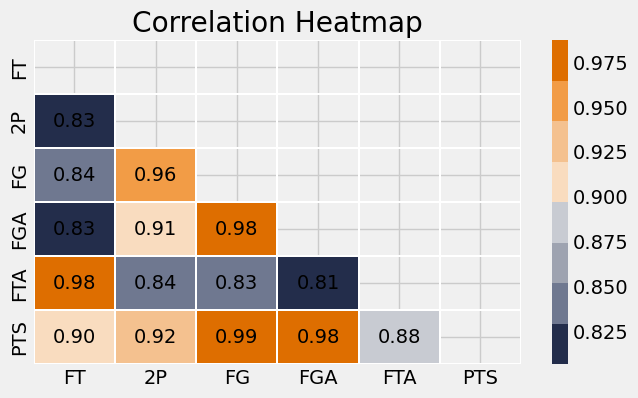

In [8]:
score_related = df[['FT', '2P', 'FG', 'FGA', 'FTA', 'PTS']]

corr_matrix_ties = score_related.corr()
plot_corr_heatmap(corr_matrix_ties, score_related)

### Points (PTS) should capture all of these, for the most part, so we'll not include FTA, FGA, FG, 2P, or FT.

### Moving to the next-highest features in terms of importance, we get:

1. OWS: 0.35701
2. MP: 0.11889
3. PTS: 0.07740
4. WS: 0.04105
5. VORP: 0.03473
6. PER: 0.03367
7. TOV: 0.01995
8. AST: 0.01787
9. TS%: 0.01356
10. Rk_Year: 0.01122

In [15]:
selected_features = ['VORP', 'PER', 'WS', 'MP', 'PTS', 'TS%', 'TOV', 'AST', 'Rk_Year', 'OWS']

---

## Selected Features:

- VORP = Value Over Replacement Player -- $[BPM - (-2.0)]*$(% of possessions played)$ * \frac{team games}{82}$.

- PER = Player Efficiency Rating (see <a href="https://www.basketball-reference.com/about/per.html">Calculating PER</a> for the formula).

- WS = Win Shares (see <a href="https://www.basketball-reference.com/about/ws.html">NBA Win Shares)</a> for information about how this feature is calculated).

- MP = Minutes Played

- OBPM = Offensive Box Plus/Minus. This is a box score that compares a player's offensive impact to the league average (see <a href="https://www.basketball-reference.com/about/bpm2.html">About Box/Plus Minus)</a> for details on calculating the offensive box score).

- TS% = True Shooting Percentage.

- TOV = Turnovers.

- AST = Assists.

- Rk_Year = Team league ranking.

- OWS = Offensive Win Shares (see <a href="https://www.basketball-reference.com/about/ws.html">NBA Win Shares)</a> for more information on how this is calculated.

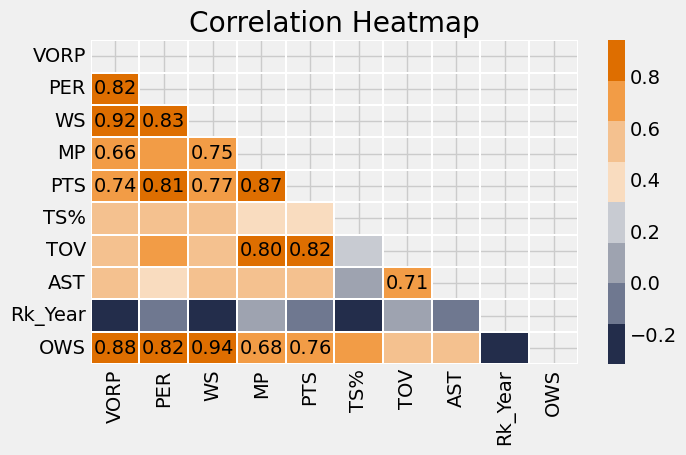

In [16]:
# Select only the columns corresponding to the top 10 features
df_check_selected = df[selected_features]
corr_matrix = df_check_selected.corr()

plot_corr_heatmap(corr_matrix, selected_features)

### Some of our selected features are highly correlated, but let's proceed to modeling and index buidling for now.

In [17]:
df_selected = df[selected_features]
df_selected.to_csv('df_selected.csv', index=False)